In [78]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import json
import pandas as pd

import lib.ext.baycon.baycon.bayesian_generator as baycon
import lib.ext.baycon.baycon.bayesian_generator as baycon
import lib.ext.baycon.baycon.time_measurement as time_measurement
from lib.ext.baycon.common.DataAnalyzer import *
from lib.ext.baycon.common.Target import Target
from lib.ext.baycon.common.ScoreCalculator import ScoreCalculator
from lib.score_calculator_kmeans import ScoreCalculatorKmeans

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Axes: >

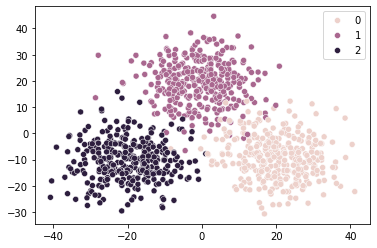

In [79]:
X, y = make_blobs(centers=3, cluster_std=8, n_features=20, n_samples=1000)

pca = PCA(n_components=2)
embed_X = pca.fit_transform(X)
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y)

In [92]:
# model = RandomForestClassifier()
model = KMeans(n_clusters=3)
model.fit(X, y)
pred = model.predict(X)
pred = [str(l) for l in pred]
stacked = np.column_stack((X, pred))
df = pd.DataFrame(stacked, columns=[f'x{i+1}' for i in range(X.shape[1])]+['label'], dtype=float)
df

/home/jacob/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x12,x13,x14,x15,x16,x17,x18,x19,x20,label
0,25.049600,10.686482,11.754263,18.719219,-11.907886,16.948269,8.601383,-2.400536,-12.712357,13.100512,...,-5.858504,5.917290,-0.121760,8.975070,-4.893549,4.840628,3.064104,10.285637,29.924155,0.0
1,-0.895842,-7.996628,-3.362064,7.106578,6.636237,-16.660882,-7.604287,15.365327,4.446782,0.671325,...,1.834747,-1.837710,-0.324041,-2.848458,-5.285441,-1.334171,1.605486,-6.568882,-7.404109,1.0
2,1.097389,-8.759487,2.265943,9.063436,5.522890,1.607061,13.802591,-5.063829,0.702197,4.679798,...,4.652831,0.261430,5.752247,1.531758,-13.290707,7.512355,17.916994,-5.822187,-4.345930,1.0
3,1.032792,-11.032269,23.223282,13.604624,-7.842875,-5.051853,14.981568,5.464591,-3.176543,12.241876,...,-16.308949,8.241898,0.875978,-4.652377,11.732270,0.928914,10.391249,-2.343765,4.040511,0.0
4,-13.160234,-3.783070,5.725842,-0.134030,8.172229,-14.831037,15.294491,0.536946,-8.738081,-6.096535,...,-8.925976,-3.502393,7.056626,2.334790,8.042436,-4.614076,-2.387796,-19.666073,18.569832,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,9.801638,-10.967762,1.569416,5.578573,-2.421465,17.517759,-9.265695,7.032451,-12.608098,-0.576202,...,-0.048151,3.484585,-6.055919,-10.734632,5.646537,7.142881,7.475536,-13.588131,-12.055075,1.0
996,5.614460,0.038741,-2.413151,16.148130,2.530938,5.696407,-3.521489,13.613674,-0.178096,7.310324,...,-4.041556,-4.644956,0.004108,1.279221,2.104071,-0.490503,10.122916,0.105097,1.964299,0.0
997,2.552455,-11.542384,-18.239579,16.707432,0.716699,-7.437132,-4.468560,-12.694865,1.755502,9.182742,...,-11.787602,-1.464552,17.565445,2.858398,7.905141,-13.452467,-2.866567,0.032925,16.383378,2.0
998,12.087827,3.105166,-15.354839,15.707636,-5.054945,13.805922,16.388630,4.684926,6.076838,12.994389,...,-18.378996,8.595895,-9.687306,9.797430,-6.331715,4.216844,8.483781,22.798682,16.279650,0.0


<Axes: >

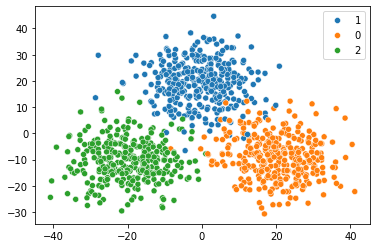

In [90]:
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=pred)

In [82]:
def execute(df, model, target, initial_instance_index, categorical_features=[], actionable_features=[]):
    y = df[[target.target_feature()]].values.ravel()
    X = df.drop([target.target_feature()], axis=1).values
    feature_names = df.columns[df.columns != target.target_feature()]

    run = 0
    data_analyzer = DataAnalyzer(X, y, feature_names, target, categorical_features, actionable_features)
    X, y = data_analyzer.data()
    initial_instance = X[initial_instance_index]
    initial_prediction = y[initial_instance_index]

    print("--- Executing... Initial Instance: {} Target: {} Run: {} ---".format(
        initial_instance_index,
        target.target_value_as_string(),
        run
    ))

    # Initialize ScoreCalculator Classification / Clustering
    initial_instance_f = initial_instance.astype(float)   # np operations need same type object to compute!
    if target.target_type() == Target.TYPE_CLASSIFICATION or target.target_type() == Target.TYPE_REGRESSION:
        score_calculator = ScoreCalculator(initial_instance, initial_prediction, target, data_analyzer)
    elif target.target_type() == Target.TYPE_CLUSTERING_KMEANS:
        # point_pred = int(model.predict([X[initial_instance_index]])[0])
        target_cluster_center = model.cluster_centers_[target._target_value]
        
        target_cluster_indices = np.where(y == target._target_value)

        min_target_cluster_distance = np.min([np.linalg.norm(i-target_cluster_center) for i in X[target_cluster_indices]])
        # max_target_cluster_distance = np.max([np.linalg.norm(i-target_cluster_center) for i in X[target_cluster_indices]])
        max_target_cluster_distance = np.max([np.linalg.norm(i-target_cluster_center) for i in X])

        base_calculator = ScoreCalculator(initial_instance, initial_prediction, target, data_analyzer)
        score_calculator = ScoreCalculatorKmeans(initial_instance, initial_prediction, target, data_analyzer, base_calculator, min_target_cluster_distance, max_target_cluster_distance, target_cluster_center)

    counterfactuals, _ranker = baycon.run(initial_instance_f, initial_prediction, target, data_analyzer, model, score_calculator)
    predictions = np.array([])
    try:
        predictions = model.predict(counterfactuals)
    except ValueError:
        pass
    output = {
        "initial_instance": initial_instance.tolist(),
        "initial_prediction": str(initial_prediction),
        "categorical_features": categorical_features,
        "actionable_features": actionable_features,
        "target_type": target.target_type(),
        "target_value": target.target_value(),
        "target_feature": target.target_feature(),
        "total_time": str(time_measurement.total_time),
        "time_to_first_solution": str(time_measurement.time_to_first_solution),
        "time_to_best_solution": str(time_measurement.time_to_best_solution),
        "counterfactuals": counterfactuals.tolist(),
        "predictions": predictions.tolist()
    }

    # output_filename = "{}_{}_{}_{}_{}_{}.json".format("bcg", dataset_name, initial_instance_index,
    #                                                   target.target_value_as_string(), model_name, run)
    # with open(output_filename, 'w') as outfile:
    #     json.dump(output, outfile)
    # print("--- Finished: saved file {}\n".format(output_filename))

    return counterfactuals, predictions, initial_instance, initial_prediction #, data_analyzer, ranker, model


In [89]:
point_idx = 0
point_pred = int(model.predict([X[point_idx]])[0])
print("Point prediction: ", point_pred, type(point_pred))
# t = Target(target_type="classification", target_feature="label", target_value=1)
t = Target(target_type="clustering_kmeans", target_feature="label", target_value=1)

cf, _predictions, _initial_instance, _initial_prediction = execute(df, model, t, point_idx)

Point prediction:  1 <class 'int'>
--- Executing... Initial Instance: 0 Target: 1 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (668) CFs (668)
Re-training surrogate model with data size: 668
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (0) Unique overall (0)
Generated random instances: (3261)
Predicted top: 20 Counterfactuals: 20
Known alternatives: 688
Best instance score 0.9495 (X 0.99951 Y 1.0 F 0.95), found on epoch: 0
Re-training surrogate model with data size: 688
--- epoch 2 ----
Generating neighbors for 20 near best instances
Generated neighbours: (88) Unique overall (88)
Generated random instances: (3227)
Predicted top: 20 Counterfactuals: 20
Known alternatives: 708
Best instance score 0.9495 (X 0.99951 Y 1.0 F 0.95), found on epoch: 0
Re-training surrogate model with data size: 708
--- epoch 3 ----
Generating neighbors fo

<Axes: >

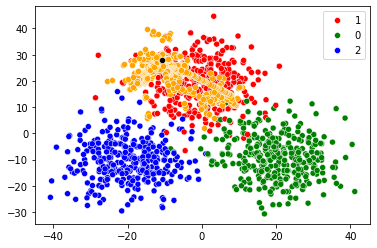

In [91]:
filtered_cfs = [i for i in cf if model.predict(i.reshape(1,-1)) == t._target_value]

embed_cf = pca.transform(filtered_cfs)
sns.scatterplot(x=embed_X[:,0], y=embed_X[:,1], hue=pred, palette=['red','green','blue'])
sns.scatterplot(x=embed_cf[:,0], y=embed_cf[:,1], color='orange')
sns.scatterplot(x=embed_X[[0],0], y=embed_X[[0],1], color='black')